In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay,roc_curve
from sklearn.svm import SVC
from time import time

In [2]:
# Read dataset
df = pd.read_csv('model_dataset_att2.csv')
df

,ID,seniority_level,desc_clean
0,1,Mid-Senior level,company descriptionthe ikigai platform unlocks...
1,4,Mid-Senior level,job title : engineerlocation : remotewho we ar...
2,21,Mid-Senior level,about usnational grid is hiring a senior data ...
3,22,Mid-Senior level,about usnational grid is hiring a senior data ...
4,23,Mid-Senior level,about usnational grid is hiring a senior data ...
...,...,...,...
736,965,Junior level,what is aviture ? aviture is a full-service te...
737,976,Junior level,location : us remotejob summarywe are seeking ...
738,980,Junior level,responsibilitiesthe business risk integrated c...
739,981,Junior level,location : us remotejob summarywe are seeking ...


In [3]:
# Fitting and transforming the vacancy texts with TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', sublinear_tf = True, ngram_range = (1,2), norm = 'l2', min_df = 4)
features = vectorizer.fit_transform(df.desc_clean).toarray()

# Splitting 'features' and the dependent variable (df.seniority_level) into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    features, df.seniority_level, train_size=500, random_state=862025)

In [4]:
%%markdown
# Singular Value Decomposition
In iterations 1 and 2, I trained the model after performing singular value decomposition resulting in 70 components. 
Because more components result in a higher explained variance (and presumably better performing models) I decide to train versions of the SVD with 70, 100, 130 and 160 components.<br>
Even though it takes the most time to train, the 160 components account for two thirds of explained variance. Thus 160 components is the choice.  

# Singular Value Decomposition
In iterations 1 and 2, I trained the model after performing singular value decomposition resulting in 70 components. 
Because more components result in a higher explained variance (and presumably better performing models) I decide to train versions of the SVD with 70, 100, 130 and 160 components.<br>
Even though it takes the most time to train, the 160 components account for two thirds of explained variance. Thus 160 components is the choice.  


In [9]:
# For loop to look at explained variance and performance of computed components
components_SVD = [70, 100, 130, 160]
variance_ratio_list = []

for component in components_SVD:
    begin_hier = time()
    svd = TruncatedSVD(n_components = component, algorithm = 'arpack')
    features_reduced = svd.fit_transform(X_train)
    end_hier = time()
    tijd = end_hier - begin_hier
    
    variance_ratio_list.append([component, svd.explained_variance_ratio_.sum(), tijd])

SVD_Results = pd.DataFrame(variance_ratio_list, columns=['Components', 'ExplainedVar', 'Time (sec)'])
SVD_Results

,Components,ExplainedVar,Time (sec)
0,70,0.450163,81.454355
1,100,0.536435,112.903211
2,130,0.609399,150.600541
3,160,0.674723,184.109929


In [5]:
# The final SVD with 160 components
svd = TruncatedSVD(n_components = 160, algorithm = 'arpack')
X_train_svd = svd.fit_transform(X_train)

In [6]:
%%markdown
# Iteration 3
### Model training and evaluation
The steps are identical to those in the training phase of the notebooks 'Iteration_1' and 'Iteration_2':
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.

# Iteration 3
### Model training and evaluation
The steps are identical to those in the training phase of the notebooks 'Iteration_1' and 'Iteration_2':
* Perform a grid search to find the best C parameter. 
* Do a cross validation on the best estimator of the training data. 
    * Evaluate the cross validation on accuracy and the Area Under Curve (AUC) score.


In [7]:
C_grid = np.linspace(0.01,5,10)
parameters = {'C': C_grid}

Logit_grid = LogisticRegression()
Log_gs_cv = GridSearchCV(Logit_grid, parameters).fit(X_train_svd, y_train)

cv_log_model = cross_validate(Log_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_log_model

{'fit_time': array([0.19665217, 0.10073805, 0.10122466]),
 'score_time': array([0.10006738, 0.09870315, 0.09810162]),
 'test_accuracy': array([0.73652695, 0.62275449, 0.65662651]),
 'test_roc_auc': array([0.8062249 , 0.70840505, 0.71868196])}

In [8]:
Log_gs_cv.best_estimator_

LogisticRegression(C=0.5644444444444445)

In [9]:
C_grid = np.linspace(0.01,5,10)
kernel_grid = ['rbf', 'linear'] 
parameters = {'C': C_grid, 'kernel': kernel_grid}

SVM_grid = SVC(probability= True)
Svm_gs_cv = GridSearchCV(SVM_grid, parameters).fit(X_train_svd, y_train)

cv_svm_model = cross_validate(Svm_gs_cv.best_estimator_, X_train_svd, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))

cv_svm_model

{'fit_time': array([0.19252753, 0.19158792, 0.19431973]),
 'score_time': array([0.09198713, 0.01747704, 0.09245825]),
 'test_accuracy': array([0.71257485, 0.61077844, 0.65662651]),
 'test_roc_auc': array([0.79302926, 0.65748709, 0.74568152])}

In [10]:
Svm_gs_cv.best_estimator_

SVC(C=0.5644444444444445, probability=True)

In [11]:
# Empty dataframe to store the results
Results_trainset = pd.DataFrame(columns = ['train_accuracy','train_auc', 'fit_time', 'score_time'])

In [12]:
def record_results(cv_model, model_name):
    """
    cv_model = cross_validate(be, X_train, y_train, 
                              cv = 3, scoring = ('accuracy', 'roc_auc'))
    """
    accuracy_score = np.mean(cv_model['test_accuracy'])
    auc_score = np.mean(cv_model['test_roc_auc'])
    fit_time = np.mean(cv_model['fit_time'])
    score_time = np.mean(cv_model['score_time'])
    
    Results_trainset.loc[model_name] = pd.Series({'train_accuracy': accuracy_score, 
                                                   'train_auc': auc_score,
                                                   'fit_time': fit_time, 
                                                   'score_time': score_time})


record_results(cv_log_model, 'Logit')
record_results(cv_svm_model, 'SVM')

In [13]:
%%markdown
##### Evaluation
For both the logistic regression and the support vector machine the training results are somewhat similar to the training result in iteration 2. 
What is otherwise noticeable is how much more time it takes to fit the logistic regression compared to the support vector machine.

##### Evaluation
For both the logistic regression and the support vector machine the training results are somewhat similar to the training result in iteration 2. 
What is otherwise noticeable is how much more time it takes to fit the logistic regression compared to the support vector machine.


In [14]:
Results_trainset

,train_accuracy,train_auc,fit_time,score_time
Logit,0.671969,0.744437,0.132872,0.098957
SVM,0.659993,0.732066,0.192812,0.067307


In [15]:
Results_trainset.to_csv('Train_results_att3.csv', index= False)

In [15]:
%%markdown
### Test results
#####  Accuracy
Both the accuracy of the logistic regression and the SVM show improvements compared to iteration 2. 
The accuracy for this iteration is 0.5477. For iteration 2 the accuracy was 0.5228.<br>
For the SVM, the accuracy is 0.5892. This is also an improvement from iteration 2, where it was 0.5519. 
Like it was the case with iteration 2 compared to iteration 1, the absolute value of the accuracy is not great 
but the improvement compared to the former version(s) is promising.<br>
What's also noticeable is that both models seem more accurate in predicting that vacancies belong to the 'Mid-Senior level' 
than predicting vacancies belong to the 'Junior level'. For implementing eventual further improvements this would be a point of attention. 
    
#####  AUC
Like the accuracy, the AUC for these versions of the models is also at its highest levels.<br>
The AUC for the logistic regression is 0.58, an increase from the 0.5651 of the second version. For the support vector machine, 
the AUC is above 0.6 for the first time (0.6152). In the second iteration the AUC of the SVM was 0.5886.
Once again, in the AUC context these are not great scores but I think the gradual improvements from the models of the first and second iterations are promising. 

### Test results
#####  Accuracy
Both the accuracy of the logistic regression and the SVM show improvements compared to iteration 2. 
The accuracy for this iteration is 0.5477. For iteration 2 the accuracy was 0.5228.<br>
For the SVM, the accuracy is 0.5892. This is also an improvement from iteration 2, where it was 0.5519. 
Like it was the case with iteration 2 compared to iteration 1, the absolute value of the accuracy is not great 
but the improvement compared to the former version(s) is promising.<br>
What's also noticeable is that both models seem more accurate in predicting that vacancies belong to the 'Mid-Senior level' 
than predicting vacancies belong to the 'Junior level'. For implementing eventual further improvements this would be a point of attention. 
    
#####  AUC
Like the accuracy, the AUC for these versions of the models is also at its highest levels.<br>
The AUC for the logistic regression is 0.58, an increase from the 0.5651 of the second version. For the support vector machine, 
the AUC is above 0.6 for the first time (0.6152). In the second iteration the AUC of the SVM was 0.5886.
Once again, in the AUC context these are not great scores but I think the gradual improvements from the models of the first and second iterations are promising. 


In [20]:
def roc_plot(prob, model):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(recode_y_test, prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve: {}'.format(model))
    plt.legend(loc="lower right")
    plt.show()

    print("The AUC score is {}".format(round(roc_auc,4)))

In [16]:
X_test_svd = svd.fit_transform(X_test)
X_test_svd

array([[ 2.10485235e-01, -1.76139646e-01, -5.38893654e-02, ...,
         2.34274963e-02, -1.13770101e-02,  5.92086150e-02],
       [ 2.29916727e-01, -9.21062661e-02,  2.66923781e-05, ...,
        -1.43580179e-02, -6.76073820e-02, -1.70583994e-02],
       [ 1.53425276e-01, -9.97801799e-02, -2.63265850e-02, ...,
         5.86152033e-02,  8.95311684e-04,  1.01779145e-01],
       ...,
       [ 2.10970185e-01, -1.18293342e-01, -1.93582724e-02, ...,
        -7.83749812e-02,  7.51499208e-03, -1.28654287e-04],
       [ 1.20211957e-01, -1.03783861e-01, -3.96497491e-02, ...,
         9.32905014e-02,  4.39154668e-02, -4.91803377e-02],
       [ 1.71137402e-01, -8.87339077e-02, -2.38302715e-02, ...,
        -1.73242712e-02,  4.05350435e-02,  2.56963694e-02]])

In [17]:
recode_map = {'Mid-Senior level': 1, 'Junior level': 0}
recode_y_test = pd.Series(y_test).replace(recode_map).astype(int)

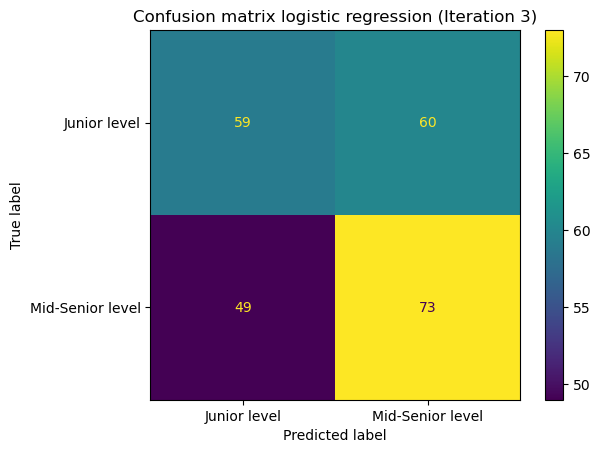

The accuracy score is 0.5477


In [18]:
logit_predictions = Log_gs_cv.best_estimator_.predict(X_test_svd)
logit_accuracy = accuracy_score(y_test, logit_predictions)

cm = confusion_matrix(y_test, logit_predictions, labels= Log_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Log_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix logistic regression (Iteration 3)')
plt.show()
print("The accuracy score is {}".format(round(logit_accuracy,4)))

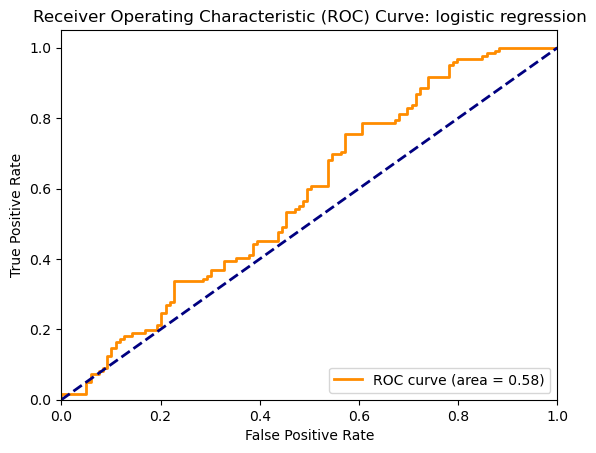

The AUC score is 0.5799


In [21]:
logit_predictions_proba = Log_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(logit_predictions_proba[:, 1],'logistic regression')

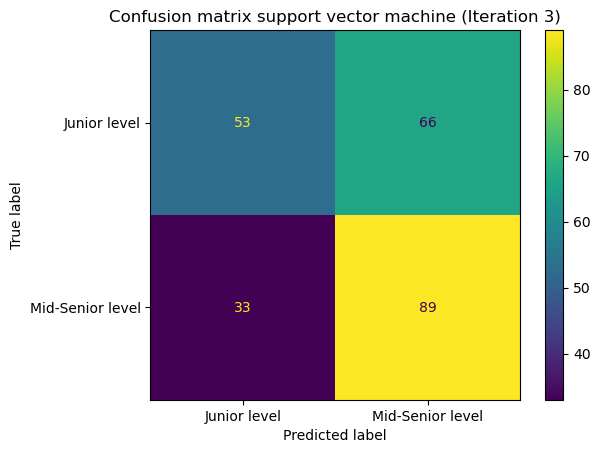

The accuracy score is 0.5892


In [22]:
svm_predictions = Svm_gs_cv.best_estimator_.predict(X_test_svd)
svm_accuracy = accuracy_score(y_test, svm_predictions)

cm = confusion_matrix(y_test, svm_predictions, labels= Svm_gs_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Svm_gs_cv.classes_)
disp.plot()
plt.title('Confusion matrix support vector machine (Iteration 3)')
plt.show()

print("The accuracy score is {}".format(round(svm_accuracy,4)))

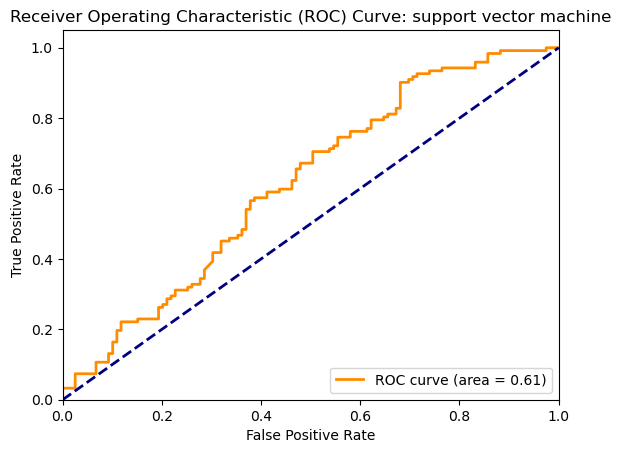

The AUC score is 0.615


In [23]:
Svm_predictions_proba = Svm_gs_cv.best_estimator_.predict_proba(X_test_svd)
roc_plot(Svm_predictions_proba[:, 1],'support vector machine')